# Analysis Plots

In this notebook, we have a look at the mean values of each feature, draw box, swarm and pairplots for every feature. Also the categorical variables are used, so sex, Academic Status and NativeSpeaker.

For this we use the whole dataset, so we also have multiple samples per person.

## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import itertools as it
from statsmodels.sandbox.stats.multicomp import multipletests
#import nltk
import sklearn.preprocessing as pp
import scipy.stats as st

import seaborn as sns
import Helper as hp

## Load .csv data with results of OpenSMILE Analysis
First we load .csv data and clean it (removing of NaNs), then we store information of all files in seperate panda dataframes containing information about affect, emotion and valence/arousal for all participants.

In [2]:
data = pd.read_csv("CHI_2019_FULL.csv")

#Set Labels for plotting
emotion_label = ['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Emo_Neutral', 'Sadness']
affect_label = ['Aggressiv', 'Cheerful', 'Intoxicated', 'Nervous', 'Aff_Neutral', 'Tired']
loi_label = ['Disinterest', 'Normal', 'High Interest']

#Get specific data and save it into new data frames
# We use the pandas .copy(deep=True) function to prevent the SettingWithCopyWarning we would otherwise get. Since we do
# not write, but only read from the data, the warning does not affect the data frames
df_emotion = data[['Anger', 'Boredom', 'Disgust', 'Fear', 'Happiness', 'Emo_Neutral', 'Sadness', 'Filename']].copy(deep=True)
df_affect = data[['Aggressiv', 'Cheerful', 'Intoxicated', 'Nervous', 'Aff_Neutral', 'Tired', 'Filename']].copy(deep=True)
df_loi = data[['Disinterest', 'Normal', 'High Interest', 'Filename']].copy(deep=True)
df_ar_val = data[['Arousal', 'Valence', 'Filename']].copy(deep=True)
#For further usage, we want to append the CharacterID as a column, which is saved with other information in the filename
#Since we only want the digits, we can remove all non-digit characters of the filename column and append the column to the df

df_emotion['Char_ID'] = df_emotion['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_affect['Char_ID'] = df_affect['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_loi['Char_ID'] = df_loi['Filename'].replace('\D+','', regex = True).copy(deep=True)
df_ar_val['Char_ID'] = df_ar_val['Filename'].replace('\D+','', regex = True).copy(deep=True)

## Let's load information about the speakers
The speaker ID is saved in a single .csv file containing four important columns: ID, Age, Sex and Acadedmic Status. Since before loaded OpenSMILE csv files are named using the corresponding index (ex. speaker with id 0 has two files 0_a.csv and 0_b.csv), so that a link can be created

In [3]:
char_data = pd.read_csv("CHI_2019_CharacterData.csv")  

#Join above tables and Character Tables

#To Join DataFrames we have to cast the column on which we want to join to int, so that both columns have the same data type
char_data['ID'] = char_data['ID'].astype(int)
df_ar_val['Char_ID'] = df_ar_val['Char_ID'].astype(int)
df_emotion['Char_ID'] = df_emotion['Char_ID'].astype(int)
df_affect['Char_ID'] = df_affect['Char_ID'].astype(int)
df_loi['Char_ID'] = df_loi['Char_ID'].astype(int)

#Safe new data frames
df_ar_val_char = df_ar_val.merge(char_data, how = 'left', left_on='Char_ID', right_on='ID')
df_emotion_char = df_emotion.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')
df_affect_char = df_affect.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')
df_loi_char = df_loi.merge(char_data, how = 'left', left_on='Char_ID', right_on= 'ID')

#Now, we only want to have data containing information about the answers
#For that we need to extract from the filename column, whether the file was part of an answer
#a = answer, p = presentation, q = question
#sentence_type should be the same for all tables, but just to be sure
arval_sentence_type = df_ar_val_char.Filename.str.replace('\d+','').str[3:-4]
df_ar_val_char['SentenceType'] = arval_sentence_type
emo_sentence_type = df_emotion_char.Filename.str.replace('\d+','').str[3:-4]
df_emotion_char['SentenceType'] = emo_sentence_type
aff_sentence_type = df_affect_char.Filename.str.replace('\d+','').str[3:-4]
df_affect_char['SentenceType'] = aff_sentence_type
loi_sentence_type = df_loi_char.Filename.str.replace('\d+','').str[3:-4]
df_loi_char['SentenceType'] = loi_sentence_type

#Now select only those who have SentenceType == 'a'
df_ar_val_char = df_ar_val_char.loc[df_ar_val_char['SentenceType'] == 'q']
df_ar_val_char = df_ar_val_char.drop(['VideoID'], axis = 1)
df_emotion_char = df_emotion_char.loc[df_emotion_char['SentenceType'] == 'q']
df_emotion_char = df_emotion_char.drop(['VideoID'], axis = 1)
df_affect_char = df_affect_char.loc[df_affect_char['SentenceType'] == 'q']
df_affect_char = df_affect_char.drop(['VideoID'], axis = 1)
df_loi_char = df_loi_char.loc[df_loi_char['SentenceType'] == 'q']
df_loi_char = df_loi_char.drop(['VideoID'], axis = 1)

affect_label.remove('Intoxicated')
df_affect_char = df_affect_char.drop(['Intoxicated'], axis = 1)
norm_test = pp.normalize(df_affect_char[affect_label], norm = 'l1')
df_affect_char[affect_label] = norm_test

df_loi_char['Normal Interest'] = df_loi_char['Disinterest'] + df_loi_char['Normal']
df_loi_char = df_loi_char.drop(['Disinterest', 'Normal'], axis = 1)
loi_label = ['Normal Interest', 'High Interest']

#Now let's compensate for multiple samples of the same person
IDs = df_emotion_char['Char_ID'].copy()
IDs.drop_duplicates()

# I know that for loops make the following operations very very slow, but I could not find a way to get this
# working with pd.apply and lambda functions... 

for i in IDs:
    #first for emotion
    for l in emotion_label:    
        emo = df_emotion_char.loc[df_emotion_char.Char_ID == i,l]
        emo_neu = hp.constructMedianSeries(emo)
        df_emotion_char.loc[df_emotion_char.Char_ID == i,l] = emo_neu
    #Then for affect
    for l in affect_label:    
        aff = df_affect_char.loc[df_affect_char.Char_ID == i,l]
        aff_neu = hp.constructMedianSeries(aff)
        df_affect_char.loc[df_affect_char.Char_ID == i,l] = aff_neu  
    for l in loi_label:    
        loi = df_loi_char.loc[df_loi_char.Char_ID == i,l]
        loi_neu = hp.constructMedianSeries(loi)
        df_loi_char.loc[df_loi_char.Char_ID == i,l] = loi_neu  
    for l in ['Arousal', 'Valence']:    
        arval = df_ar_val_char.loc[df_ar_val_char.Char_ID == i,l]
        arval_neu = hp.constructMedianSeries(arval)
        df_ar_val_char.loc[df_ar_val_char.Char_ID == i,l] = arval_neu  
        
#Now let's drop the duplicate values, since we only need one row now per person
df_emotion_char.drop_duplicates(subset=['ID'], inplace = True)
df_affect_char.drop_duplicates(subset=['ID'], inplace = True)
df_loi_char.drop_duplicates(subset=['ID'], inplace = True)
df_ar_val_char.drop_duplicates(subset=['ID'], inplace = True)    

## Now let's have another look at the plots using the character data
### Let's take a look at female/male

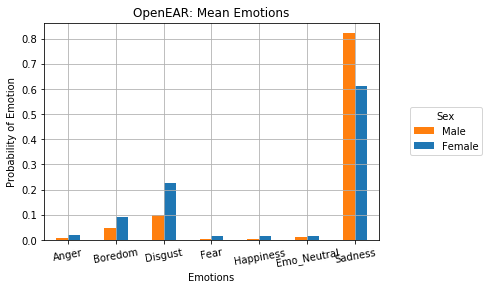

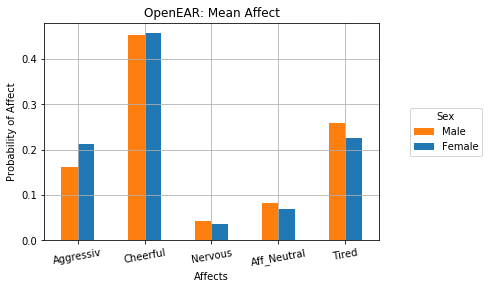

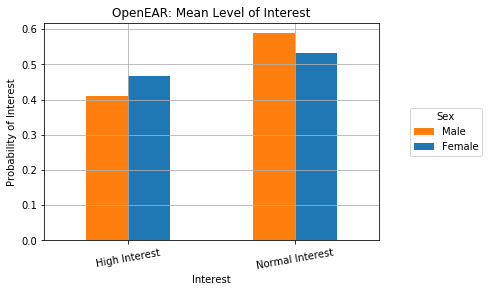

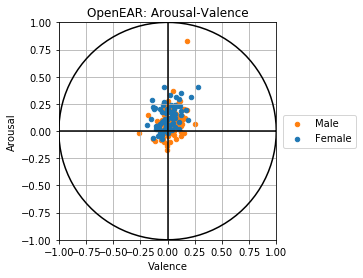

In [4]:
df_ar_val_male = df_ar_val_char.loc[df_ar_val_char['Sex'] == 'Male']
df_ar_val_female = df_ar_val_char.loc[df_ar_val_char['Sex'] == 'Female']

df_emotion_char_male = df_emotion_char.loc[df_emotion_char['Sex'] == 'Male']
df_emotion_char_female = df_emotion_char.loc[df_emotion_char['Sex'] == 'Female']

df_affect_char_male = df_affect_char.loc[df_affect_char['Sex'] == 'Male']
df_affect_char_female = df_affect_char.loc[df_affect_char['Sex'] == 'Female']

df_loi_char_male = df_loi_char.loc[df_loi_char['Sex'] == 'Male']
df_loi_char_female = df_loi_char.loc[df_loi_char['Sex'] == 'Female']

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emo_sex = hp.createMeanDataFrame([df_emotion_char_male, df_emotion_char_female],'Sex',emotion_label)
df_aff_sex = hp.createMeanDataFrame([df_affect_char_male, df_affect_char_female],'Sex',affect_label)
df_loi_sex = hp.createMeanDataFrame([df_loi_char_male, df_loi_char_female],'Sex',loi_label)

# Start with Emotion
ax_emo = df_emo_sex.plot.bar(title = 'OpenEAR: Mean Emotions',rot = 10, color = ['tab:orange','tab:blue']) #We set rotation to 10 so that the filenames can be read
ax_emo.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_emo.set_ylabel('Probability of Emotion')
ax_emo.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff = df_aff_sex.plot.bar(title = 'OpenEAR: Mean Affect',rot = 10, color = ['tab:orange','tab:blue']) #We set rotation to 10 so that the filenames can be read
ax_aff.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_aff.set_ylabel('Probability of Affect')
ax_aff.set_xlabel('Affects')
plt.grid(True)

#Now Level of Interest
ax_loi = df_loi_sex.plot.bar(title = 'OpenEAR: Mean Level of Interest',rot = 10, color = ['tab:orange','tab:blue']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'Sex')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Interest')
plt.grid(True)

#And finally arousal valence
ax1 = df_ar_val_male.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Male', c = 'tab:orange')
ax2 = df_ar_val_female.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Female', c = 'tab:blue', ax=ax1)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax1.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax1.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax1.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.title('OpenEAR: Arousal-Valence')
ax1.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)



## Now Plot Means of Native Speaker

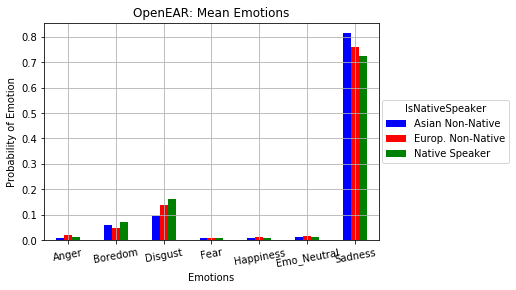

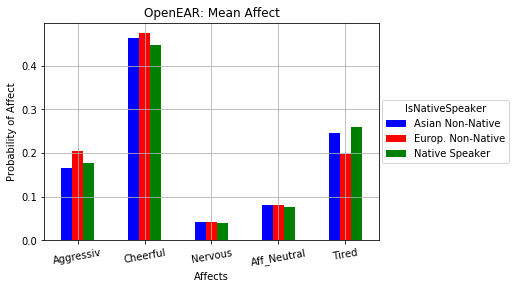

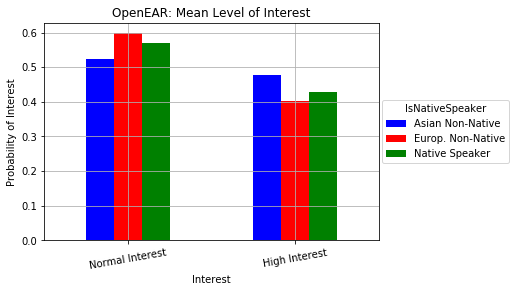

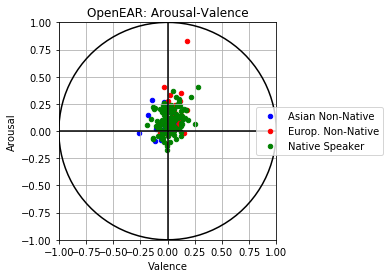

In [5]:
df_ar_val_as = df_ar_val_char.loc[df_ar_val_char['IsNativeSpeaker'] == 'Asian Non-Native']
df_ar_val_eu = df_ar_val_char.loc[df_ar_val_char['IsNativeSpeaker'] == 'Europ. Non-Native']
df_ar_val_na = df_ar_val_char.loc[df_loi_char['IsNativeSpeaker'] == 'Native Speaker']

df_emotion_char_as = df_emotion_char.loc[df_emotion_char['IsNativeSpeaker'] == 'Asian Non-Native']
df_emotion_char_eu = df_emotion_char.loc[df_emotion_char['IsNativeSpeaker'] == 'Europ. Non-Native']
df_emotion_char_na = df_emotion_char.loc[df_loi_char['IsNativeSpeaker'] == 'Native Speaker']

df_affect_char_as = df_affect_char.loc[df_affect_char['IsNativeSpeaker'] == 'Asian Non-Native']
df_affect_char_eu = df_affect_char.loc[df_affect_char['IsNativeSpeaker'] == 'Europ. Non-Native']
df_affect_char_na = df_affect_char.loc[df_loi_char['IsNativeSpeaker'] == 'Native Speaker']

df_loi_char_as = df_loi_char.loc[df_loi_char['IsNativeSpeaker'] == 'Asian Non-Native']
df_loi_char_eu = df_loi_char.loc[df_loi_char['IsNativeSpeaker'] == 'Europ. Non-Native']
df_loi_char_na = df_loi_char.loc[df_loi_char['IsNativeSpeaker'] == 'Native Speaker']

#For Plotting, lets calculate the mean emotion value for all audiofiles
df_emo_nat = hp.createMeanDataFrame([df_emotion_char_as, df_emotion_char_eu, df_emotion_char_na],'IsNativeSpeaker',emotion_label)
df_aff_nat = hp.createMeanDataFrame([df_affect_char_as, df_affect_char_eu, df_affect_char_na],'IsNativeSpeaker',affect_label)
df_loi_nat = hp.createMeanDataFrame([df_loi_char_as, df_loi_char_eu, df_loi_char_na],'IsNativeSpeaker',loi_label)

# Start with Emotion
ax_emo = df_emo_nat.plot.bar(title = 'OpenEAR: Mean Emotions',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_emo.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'IsNativeSpeaker')
ax_emo.set_ylabel('Probability of Emotion')
ax_emo.set_xlabel('Emotions')
plt.grid(True)

#Now let's plot affect bar diagram
ax_aff = df_aff_nat.plot.bar(title = 'OpenEAR: Mean Affect',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_aff.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'IsNativeSpeaker')
ax_aff.set_ylabel('Probability of Affect')
ax_aff.set_xlabel('Affects')
plt.grid(True)

#Now Level of Interest
ax_loi = df_loi_nat.plot.bar(title = 'OpenEAR: Mean Level of Interest',rot = 10, color = ['b','r', 'g']) #We set rotation to 10 so that the filenames can be read
ax_loi.legend(loc = 'center', bbox_to_anchor=(1.2,0.5), title = 'IsNativeSpeaker')
ax_loi.set_ylabel('Probability of Interest')
ax_loi.set_xlabel('Interest')
plt.grid(True)

#And finally arousal valence
ax1 = df_ar_val_as.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Asian Non-Native', c = 'b')
ax2 = df_ar_val_eu.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Europ. Non-Native', c = 'r', ax=ax1)
ax3 = df_ar_val_na.plot.scatter(x = 'Valence', y = 'Arousal', label = 'Native Speaker', c = 'g', ax=ax1)
#We want to plot the arousal valence circle so we create values for it
t = np.linspace(0,np.pi*2,100)
ax1.plot(np.cos(t), np.sin(t), linewidth = 1.5, color = 'black')
ax1.axvline(0,0,1, c = 'black')
x_coord = [-1.0,1.0]
y_coord = [0.0,0.0]
ax1.plot(x_coord, y_coord, c = 'black')

#Make Plot pretty
ax1.legend(loc = 'center', bbox_to_anchor=(1.2,0.5))
plt.grid(True)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.title('OpenEAR: Arousal-Valence')
ax1.set_aspect('equal')
plt.locator_params(axis='x',nbins= 9)

## Distribution Plots
We want to take a look at the distribution of our emotions, affects, level of interest and arousal-valence. So, every emotion, e.g. anger is plotted using seaborns kdeplot().

For Arousal-Valence, we'll use jointplot(kind = "kde")

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0.98,'Distribution of Arousal and Valence')

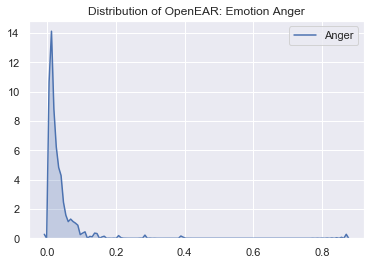

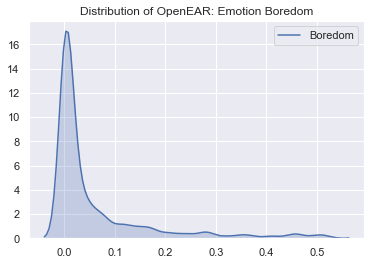

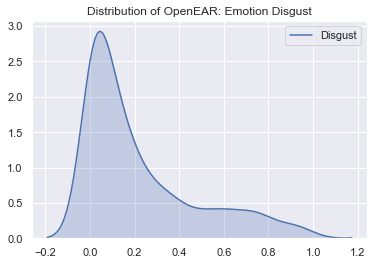

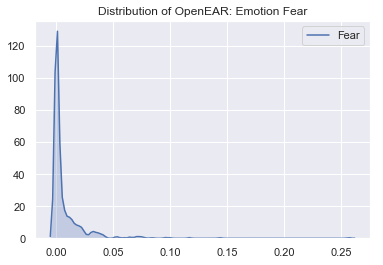

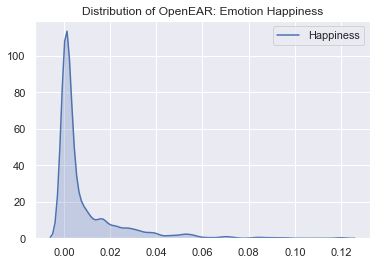

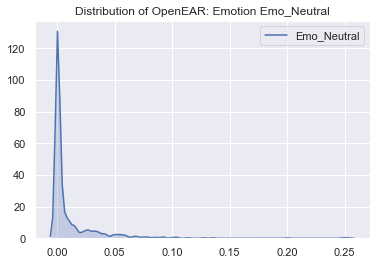

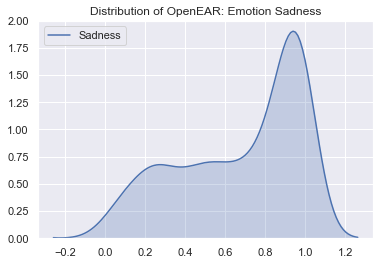

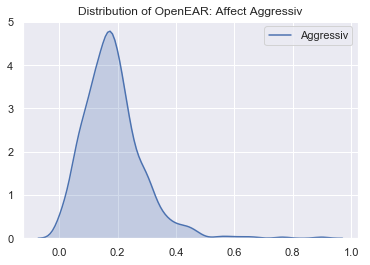

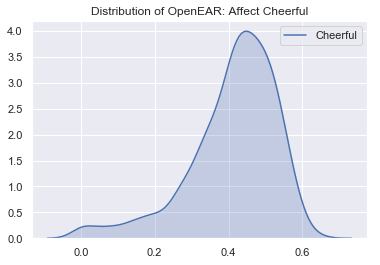

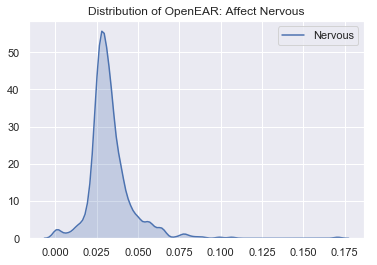

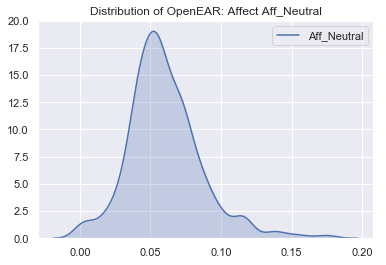

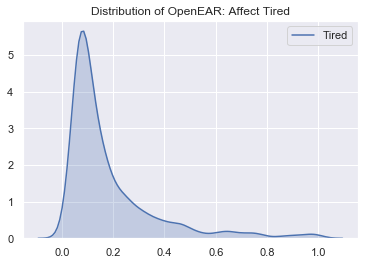

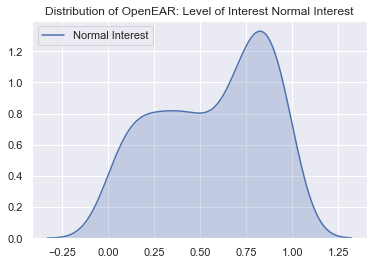

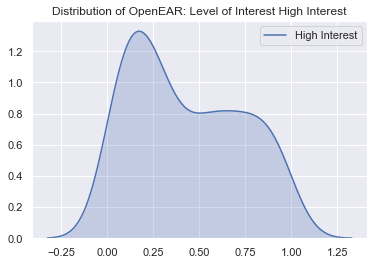

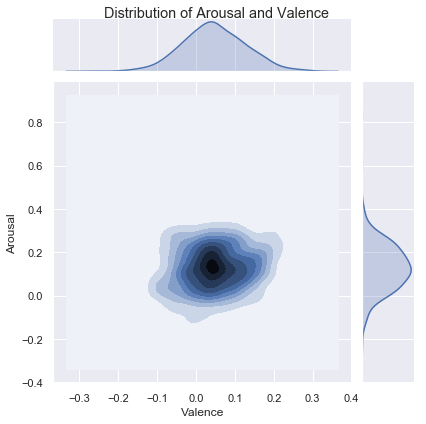

In [6]:
sns.set()
hp.distPlots(df_emotion, emotion_label, 0)
hp.distPlots(df_affect, affect_label, 1)
hp.distPlots(df_loi_char, loi_label, 2)
df_dis_ar_val_sex = df_ar_val_char.drop(['SentenceType', 'Char_ID','ID','Filename', 'Sex', 'Academic Status', 'IsNativeSpeaker','VideoTitle', 'Name'], axis = 1)
grid = sns.jointplot(x = "Valence", y = "Arousal", data = df_ar_val, kind = "kde")
ax = grid.ax_joint
grid.fig.subplots_adjust(top = 0.95)
grid.fig.suptitle('Distribution of Arousal and Valence')

## Swarm Plots of categorical data in relation to characteristic features

So these swarmplots are only there to get a feeling for the data, as wen can visualize each sample in a nice way, they won't be used in the analysis.

### Starting with Sex

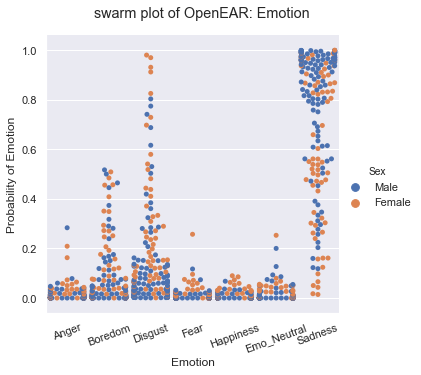

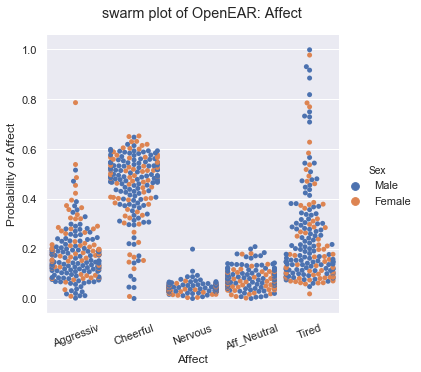

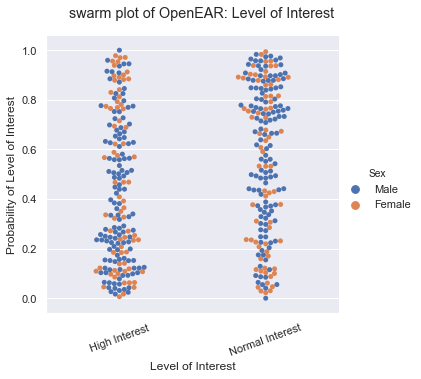

In [7]:
#Start plotting distribution of categorical data with seaborn
#e.g. emotions and sex

df_dis_emotion_sex = df_emotion_char.drop(['SentenceType','Char_ID','ID','Filename', 'Academic Status','IsNativeSpeaker', 'VideoTitle', 'Name'], axis = 1)
df_dis_affect_sex = df_affect_char.drop(['SentenceType','Char_ID','ID','Filename', 'Academic Status', 'IsNativeSpeaker','VideoTitle', 'Name'], axis = 1)
df_dis_loi_sex = df_loi_char.drop(['SentenceType','Char_ID','ID','Filename', 'Academic Status', 'VideoTitle','IsNativeSpeaker', 'Name'], axis = 1)

hp.catPlot(df_dis_emotion_sex, 'Emotion', 'Sex', 'swarm')
plt.xticks(rotation=20)

hp.catPlot(df_dis_affect_sex, 'Affect', 'Sex', 'swarm')
plt.xticks(rotation=20)

hp.catPlot(df_dis_loi_sex, 'Level of Interest', 'Sex', 'swarm')

### Now Native Speaker

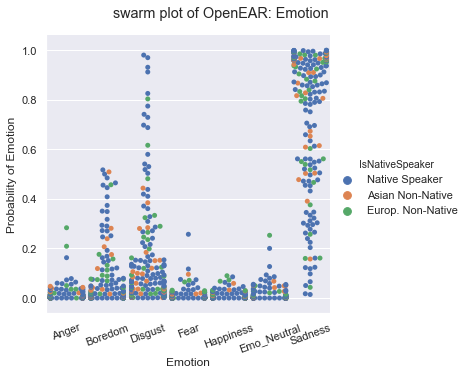

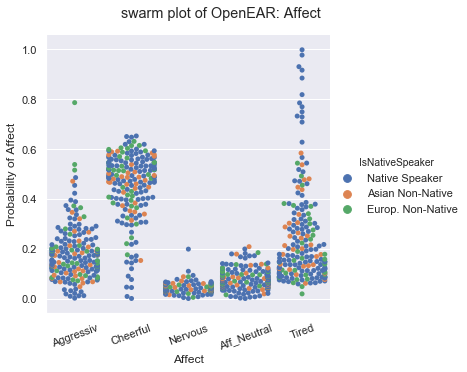

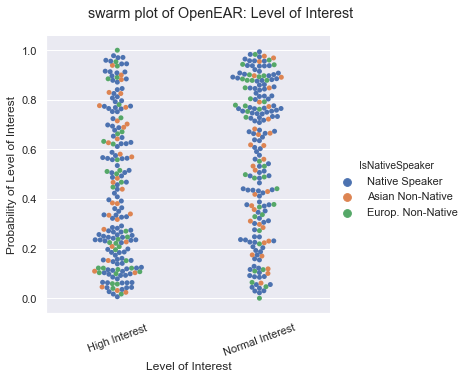

In [8]:
df_dis_emotion_nat = df_emotion_char.drop(['SentenceType','Char_ID','ID','Filename', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_emotion_nat, 'Emotion', 'IsNativeSpeaker', 'swarm')
df_dis_affect_nat = df_affect_char.drop(['SentenceType','Char_ID','ID','Filename', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_affect_nat, 'Affect', 'IsNativeSpeaker', 'swarm')
df_dis_loi_nat = df_loi_char.drop(['SentenceType','Char_ID','ID','Filename', 'Sex', 'Academic Status', 'VideoTitle', 'Name'], axis = 1)
hp.catPlot(df_dis_loi_nat, 'Level of Interest', 'IsNativeSpeaker', 'swarm')

## Pairplots
### Starting with Emotions and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = sex')

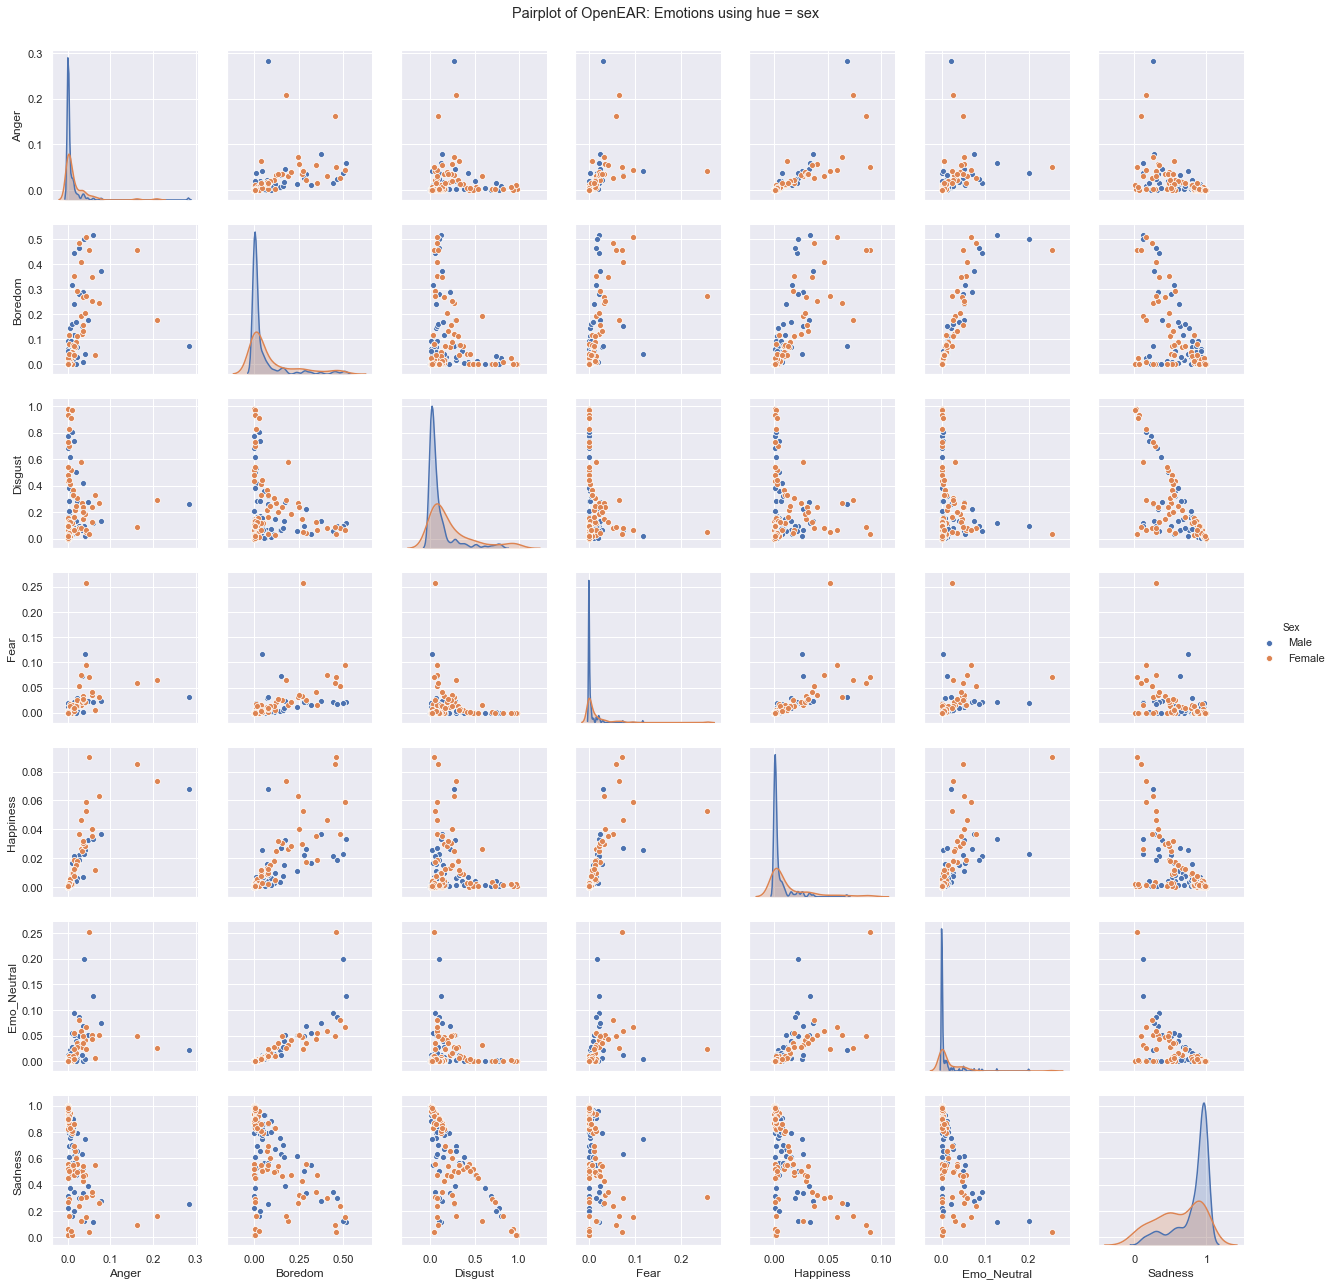

In [9]:
g = sns.pairplot(df_dis_emotion_sex, hue = "Sex")
#plt.subplots_adjust(top = 1.0)
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = sex', y = 1.02)


### Affect and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Affect using hue = sex')

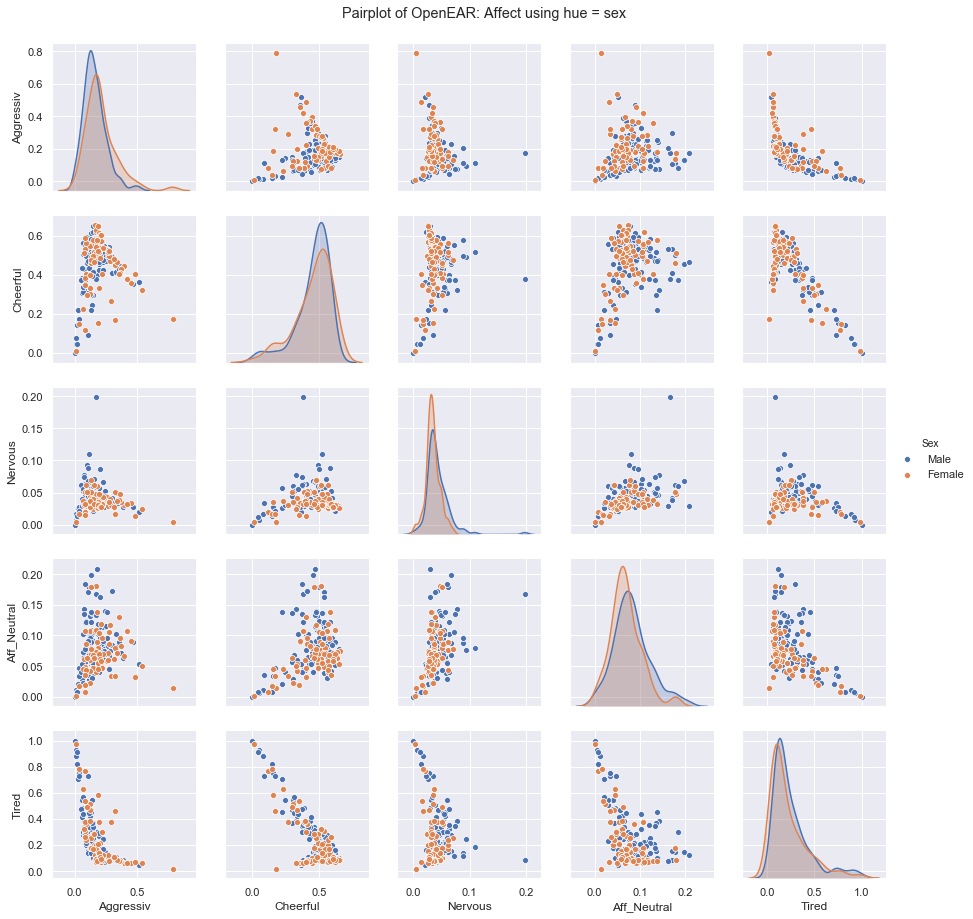

In [10]:
g = sns.pairplot(df_dis_affect_sex, hue = "Sex")
g.fig.suptitle('Pairplot of OpenEAR: Affect using hue = sex', y = 1.02)




### Level of Interest and Sex

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Level of Interest using hue = sex')

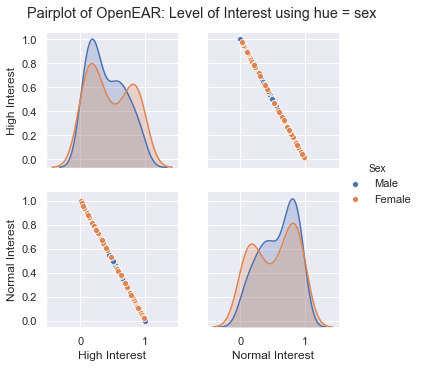

In [11]:
g = sns.pairplot(df_dis_loi_sex, hue = "Sex")
g.fig.suptitle('Pairplot of OpenEAR: Level of Interest using hue = sex', y = 1.02)


### Emotion and Native Speaker

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = IsNativeSpeaker')

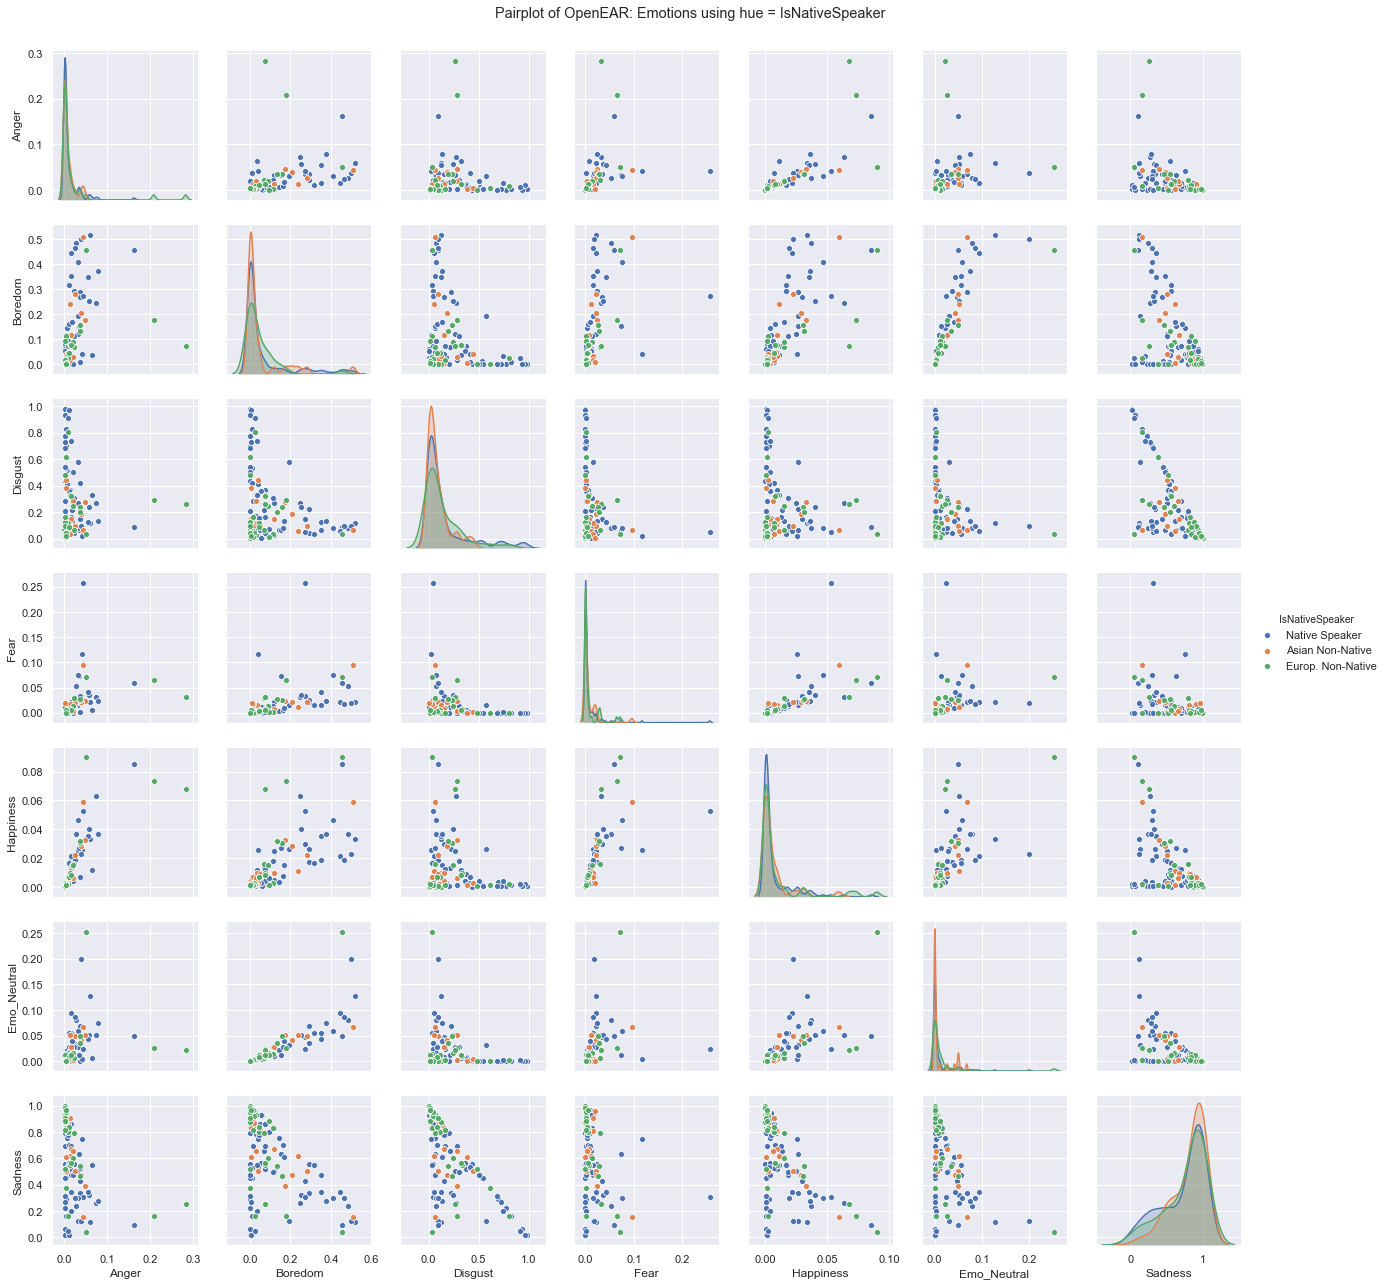

In [12]:
g = sns.pairplot(df_dis_emotion_nat, hue = "IsNativeSpeaker")
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = IsNativeSpeaker', y = 1.02)

### Affect and Native Speaker

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = IsNativeSpeaker')

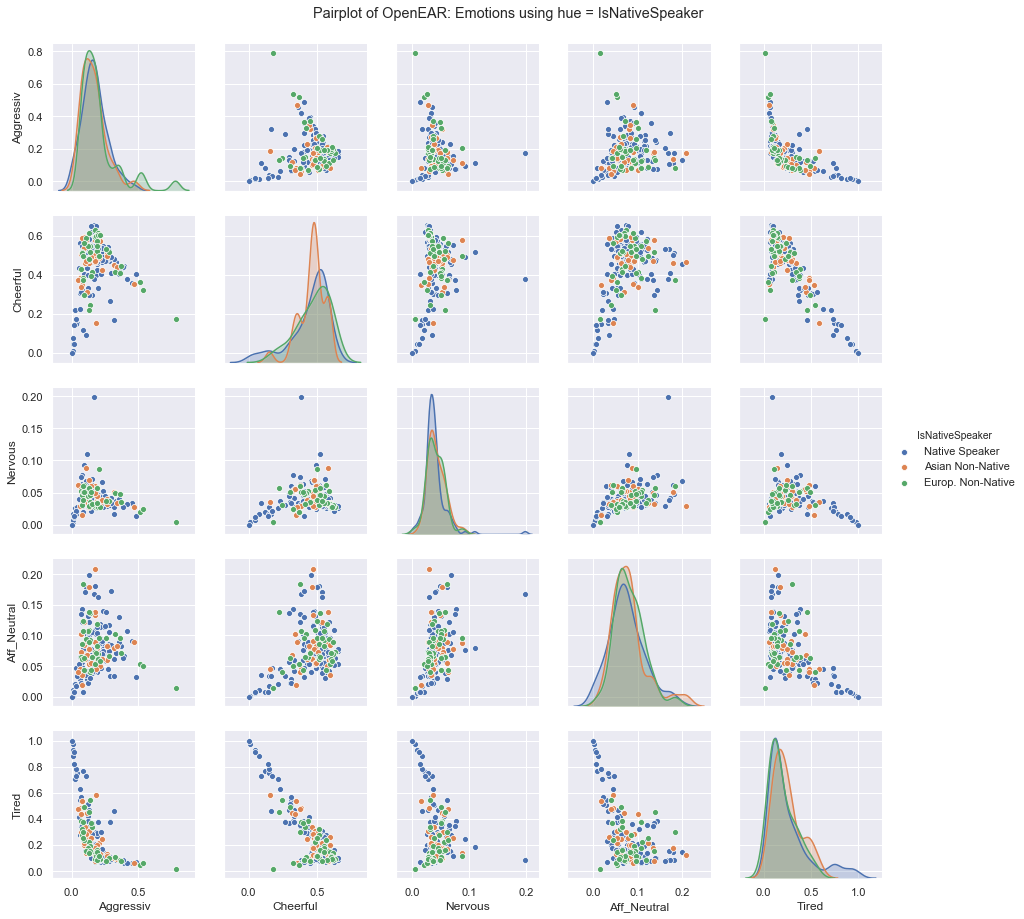

In [13]:
g = sns.pairplot(df_dis_affect_nat, hue = "IsNativeSpeaker")
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = IsNativeSpeaker', y = 1.02)

### Level of Interest and Native Speaker

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1.02,'Pairplot of OpenEAR: Emotions using hue = IsNativeSpeaker')

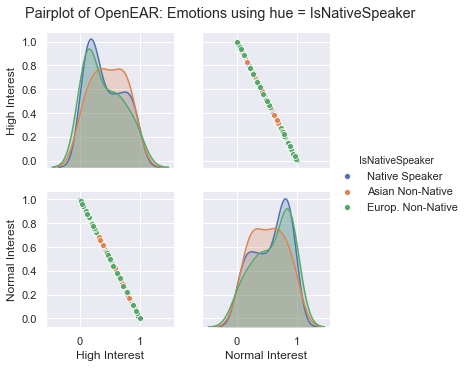

In [14]:
g = sns.pairplot(df_dis_loi_nat, hue = "IsNativeSpeaker")
g.fig.suptitle('Pairplot of OpenEAR: Emotions using hue = IsNativeSpeaker', y = 1.02)

## Box Plots
### Start with Sex

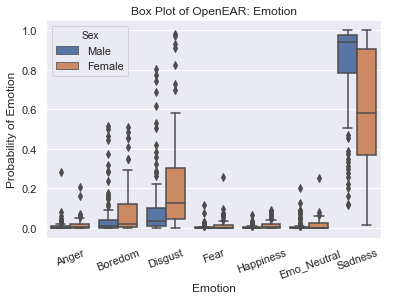

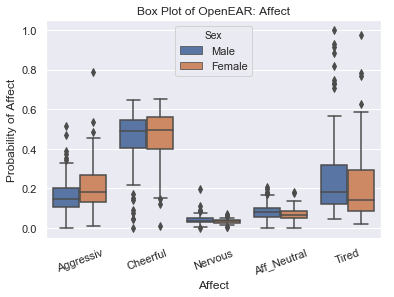

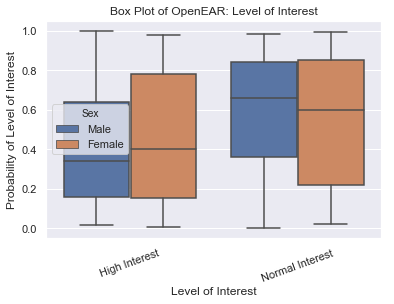

<Figure size 432x288 with 0 Axes>

In [15]:
hp.boxPlots([df_dis_emotion_sex,df_dis_affect_sex, df_dis_loi_sex], 'Sex', ['Emotion', 'Affect', 'Level of Interest'])

### Go on with Native Speaker

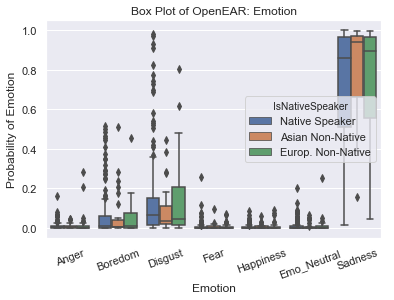

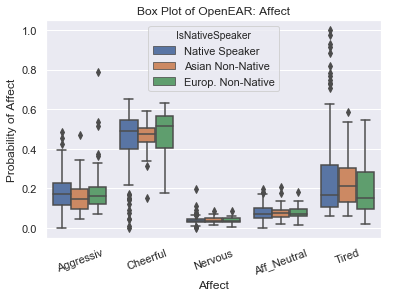

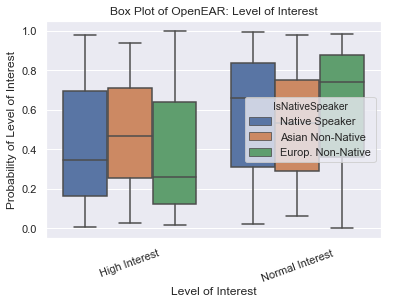

<Figure size 432x288 with 0 Axes>

In [16]:
hp.boxPlots([df_dis_emotion_nat,df_dis_affect_nat, df_dis_loi_nat], 'IsNativeSpeaker', ['Emotion', 'Affect', 'Level of Interest'])